# **Ensemble methods and Cross Validation**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

## Define the ID3 decision tree class

In [2]:
class DecisionTree:
    def __init__(self, maxdepth=np.inf):
        self.tree = {}
        self.maxdepth = maxdepth

    # Calculate the entropy of a given dataset, the distribution is over the target class.
    def calculate_entropy(self, data):
        labels = data.iloc[:, -1]
        # Your code goes here
        labels_distribution = np.sum(labels == 'unacc'), np.sum(labels == 'acc'), np.sum(labels == 'good'), np.sum(
            labels == 'vgood')
        labels_distribution = np.array(labels_distribution) / len(labels)
        labels_entropy = -np.sum(labels_distribution * np.log(labels_distribution + 1e-10))
        return labels_entropy

    # Calculate the information gain of a feature based on its value
    def calculate_information_gain(self, data, feature):
        total_entropy = self.calculate_entropy(data)
        information_gain = total_entropy

        distincts = list(set(data[feature]))  # get the values of the feature

        # Your code goes here
        feature_entropy_distribution = np.array(
            [np.sum(data[feature] == distinct) * self.calculate_entropy(self.filter_data(data, feature, distinct)) for
             distinct in distincts])
        feature_entropy_distribution /= data.shape[0]
        information_gain -= np.sum(feature_entropy_distribution)
        return information_gain

    def filter_data(self, data, feature, value):
        return data[data[feature] == value].drop(feature, axis=1)

    def create_tree(self, data, depth=0):
        # Recursive function to create the decision tree
        labels = data.iloc[:, -1]

        # Base case: if all labels are the same, return the label
        if len(np.unique(labels)) == 1:
            return list(labels)[0]

        features = data.columns.tolist()[:-1]

        # Base case: if there are no features left to split on, return the majority label
        if len(features) == 0 or depth == self.maxdepth:
            unique_labels, label_counts = np.unique(labels, return_counts=True)
            majority_label = unique_labels[label_counts.argmax()]
            return majority_label

        selected_feature = None
        best_gain = 0

        # Select feature that maximizes gain
        for feature in features:
            gain = self.calculate_information_gain(data, feature)
            if gain > best_gain:
                selected_feature = feature
                best_gain = gain

        # Create the tree node
        tree_node = {}

        distincts = list(set(data[selected_feature]))
        for value in distincts:
            new_data = self.filter_data(data, selected_feature, value)
            tree_node[(selected_feature, value)] = self.create_tree(new_data, depth + 1)

        return tree_node

    def fit(self, data):
        self.tree = self.create_tree(data)

    def predict(self, X):
        X = [row[1] for row in X.iterrows()]

        # Predict the labels for new data points
        predictions = []

        for row in X:
            current_node = self.tree
            while isinstance(current_node, dict):
                split_condition = next(iter(current_node))
                feature, value = split_condition
                current_node = current_node[feature, row[feature]]
            predictions.append(current_node)

        return predictions

    def _plot(self, tree, indent):
        depth = 1
        for key, value in tree.items():
            if isinstance(value, dict):
                print(" " * indent + str(key) + ":")
                depth = max(depth, 1 + self._plot(value, indent + 2))
            else:
                print(" " * indent + str(key) + ": " + str(value))
        return depth

    def plot(self):
        depth = self._plot(self.tree, 0)
        print(f'depth is {depth}')

In [3]:
class RandomForest:
    def __init__(self, maxdepth=np.inf, n_estimators=3, method='simple'):
        self.forest = []
        self.maxdepth = maxdepth
        self.n_estimators = n_estimators
        self.method = method

    def select_features(self, data):
        np.random.seed(40 + len(self.forest))

        if self.method == 'sqrt':
            m = int(np.sqrt(len(data.columns) - 1))
        elif self.method == 'log':
            m = int(np.log2(len(data.columns) - 1))
        else:
            m = np.random.randint(0, len(data.columns))

        incidies = np.random.choice(np.arange(0, len(data.columns) - 1), size=m, replace=False)
        features = list(data.columns[incidies])
        return data[features + ['class']]

    def fit(self, data):
        self.forest = []

        # Your code goes here
        for i in range(self.n_estimators):
            i_tree = DecisionTree(self.maxdepth)
            i_tree.fit(self.select_features(data))
            self.forest.append(i_tree)

    def _predict(self, X):
        # Predict the labels for new data points
        predictions = []

        preds = [tree.predict(X) for tree in self.forest]
        preds = list(zip(*preds))
        predictions = [Counter(est).most_common(1)[0][0] for est in preds]

        return predictions

    def score(self, X, sample_weight=None):
        pred = self._predict(X)
        return (pred == X.iloc[:, -1]).sum() / len(X)

In [4]:
def KFold(data, model, cv=5):
    chunks = np.array_split(data, cv)
    correct_sum = 0
    # Your code goes here
    for i in range(cv):
        train_data_i = pd.concat(chunks[:i] + chunks[i+1:])
        model.fit(train_data_i)
        correct_sum += model.score(chunks[i])
    return correct_sum / cv

In [5]:
data = pd.read_csv('cars.csv')

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=13)

## SECTION B

Run single decision tree:

In [7]:
tree = DecisionTree(maxdepth=3)
tree.fit(train)

pred = tree.predict(train)
acc = (pred == train.iloc[:,-1]).sum() / len(train)
print(f'Decision Tree Training accuracy is {acc}')

pred = tree.predict(test)
acc = (pred == test.iloc[:,-1]).sum() / len(test)
print(f'Decision Tree Test accuracy is {acc}')
print()

Decision Tree Training accuracy is 0.8147612156295224
Decision Tree Test accuracy is 0.838150289017341



Run random forest:

In [8]:
forest = RandomForest(maxdepth=3, n_estimators=5, method='simple')
forest.fit(train)

acc = forest.score(train)
print(f'Random Forest Training accuracy is {acc}')

acc = forest.score(test)
print(f'Random Forest Test accuracy is {acc}')

Random Forest Training accuracy is 0.808972503617945
Random Forest Test accuracy is 0.8439306358381503


## SECTION C

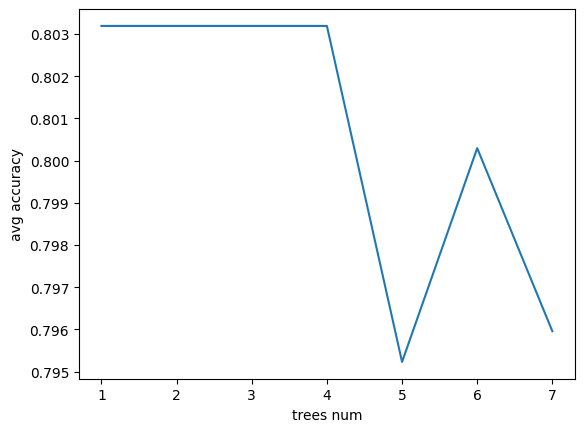

In [9]:
correct = []

for i in range(1, 8):
    forest = RandomForest(maxdepth=3, n_estimators=i, method='simple')
    correct.append(KFold(data=train, model=forest, cv=5))

plt.plot(range(1,8), np.array(correct))
plt.xlabel('trees num')
plt.ylabel('avg accuracy')
plt.show()